*This jupyter notebook present the processing performed in the manuscript:*

## Storing the portrait of *Antoine de Lavoisier* in a Single Macromolecule

Authors: *Eline Laurent,
    Jean-Arthur Amalian,
    Kevin Launay,
    Jean-Louis Clément,
    Didier Gigmes,
    Alexandre Burel,
    Christine Carapito,
    Laurence Charles,
    Marc-André Delsuc,
    and Jean-François Lutz*

*submitted for publication*

The purpose is to code a picture in a single macromolecule.
The picture consists of 20x22 black or white pixels, coded as 1 or 0.
The  use Arithmetic Coding to compress the signal.
Then the bits are concatenated into a single bit-stream, and this signal is coded in a polymer using 8 different monomers, coding for 3 bits each.

The details on the synthesis steps and signal recovery by MS/MS can be found in the full publication.

The code for an arithmetic compressor is based on the code from ["Project Nayuki"](https://www.nayuki.io/page/reference-arithmetic-coding)

downloaded from https://github.com/nayuki/Reference-arithmetic-coding

<p xmlns:dct="http://purl.org/dc/terms/" xmlns:cc="http://creativecommons.org/ns#" class="license-text">This work   is licensed under <a rel="license" href="https://creativecommons.org/licenses/by/4.0">CC BY 4.0<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1" /><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1" /></a></p>

## first implement the code used for display and compression
coded in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Some basic tools
# we use the following conventions:
#    Signal is the binary signal to code/decode           - coded into a np.array
#    Message is the molecular organisation of the signal  - coded into a list

# converters
Codon = 3  # number of bits carried by the monomers    3 ⇒ 8 monomers M1...M8
 
def decodon(lett, code=Codon):
    """
    given a letter returns bit pattern in given code
    decodon("M1", 3) == [0 0 0]
    decodon("M3", 2) == [1 0]
    """
    n = int(lett[1:])-1
    form = "{:0>%db}"%(code)
    s = form.format(n)
    return [int(l) for l in s]  # make it list
def codon(pat):
    """
    given a bit pattern, returns its name in letter
    [0 0 0] = "M1"
    [1 0] = "M3"   etc...
    """
    s = sum([(2**i) * pat[-1-i] for i in range(len(pat))] ) 
    return 'M%d'%(s+1)

def sig2msg(signal, code=Codon):
    "code a signal into a message"
    return [codon(signal[i:i+code]) for i in range(0,len(signal),code)]
def msg2sig(msg, code=Codon):
    "decode a message into a signal"
    return np.array(sum(map(decodon,msg),[]))

# checksun handling
def addcs(argsignal):
    """this function takes a signal, as a list of bits and add on cs at the end
    """
    signal = list(argsignal)
    cs = sum(signal)%2
    signal.append(cs)
    return signal
def checkcs(argsignal):
    signal = list(argsignal)
    cs = signal.pop()
    if cs != sum(signal)%2:
        print('**WARNING** the checsum is not valid')
    else:
        print('valid checksum')
    return np.array(signal)

# tools on pictures
def pcheck(pict):
    "verifies that pict (whatever format) is correct, and return a formated pict array"
    p = np.array(pict)
    if len(p.shape) == 1:
        p = p.reshape(SizeH,SizeW)
    else:
        p.shape != (SizeW, SizeH)
#        print(p.shape)
    return p
def draw( pict ):
    "draws a pixelated picture"
    plt.figure()
    plt.imshow(pcheck(pict), cmap="Greys")
    

In [3]:
# exemple given
sig = [1,1,1,0,1,1,1,1,0,0,0,1,0,0,0]
print('signal:\t\t',sig)
sigcs = addcs(sig)
print('signal + cs :\t',sigcs)
msg = sig2msg(sigcs)
print('coded message:\t',msg)

signal:		 [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
signal + cs :	 [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
coded message:	 ['M8', 'M4', 'M7', 'M2', 'M1', 'M1']


In [4]:
# the following code implements an arithmetic compresser
# based on the code from "Project Nayuki", https://www.nayuki.io/page/reference-arithmetic-coding
# dowloaded 2020-03-10
import io
import arithm_coding.arithmeticcoding  as ar     # as found in Project Nayuki
# implement an in-memory input/ouput stream
class BitInputStream(object):
    "Constructs a fake bit input stream"
    def __init__(self, inp,nbits):
        "inp is a list of 1 and 0"
        self.inp = inp
        self.nbits = nbits
    def read(self):
        try:
            return self.inp.pop(0)
        except:
            return -1
    def _repr_(self):
        self.inp._repr_()
class BitOutputStream(object):
    "Constructs a fake bit output stream"
    def __init__(self,nbits):
        self.out = []
        self.nbits = nbits
    def write(self, b):
        "Writes a bit to the stream. The given bit must be 0 or 1."
        if b not in (0, 1):
            raise ValueError("Argument must be 0 or 1")
        self.out.append(b)
    def close(self):
        pass
#        print(self.out)
    def _repr_(self):
        self.out._repr_()
# Code using ARCoder
class ARCoder():
    def __init__(self,nbits, verbose=True):
        if nbits <2 or nbits>8 :
            raise ValueError('N should be a value between 2 and 8')
        self.nbits = nbits
        self.sz = 2**nbits
        self.sig = None
        self.verbose = verbose
    def set_signal(self, signal):
        "to be called after initialization for coding"
        self.sig = self.align(signal)
        self.comp_frequencies()
    # compute frequencies
    def set_freq(self, freqs):
        "to be called after initialization for decoding - freqs is the frequency table computed by the coder"
        self.freqs = freqs
    def align(self, sig):
        "complete signal with trailing 0 so length is a multiple of 2^nbits"
        asig = [s for s in sig]
        while len(asig) % self.sz != 0:
            asig.append(0)
        return asig
    def comp_frequencies(self):
        "compute the frequency table from the signal"
        freqs = ar.SimpleFrequencyTable([0] * (self.sz+1))
        for i in range(0,len(self.sig), self.nbits):
            symb = 0
            for j in range(self.nbits):
                if i+j < len(self.sig):
                    v = self.sig[i+j]
                    symb = 2*symb + v
                else:
                    break
            freqs.increment(symb)
        freqs.increment(self.sz)  # marks end of stream
        self.freqs = freqs
    def compress(self):
        "return the compressed signal from the signal"
        out = open('toto','wb')
        bits = ar.BitOutputStream(out)
        coder = ar.ArithmeticEncoder(32,bits)
        for i in range(0,len(self.sig), self.nbits):
            symb = 0
            for j in range(self.nbits):
                if i+j < len(self.sig):
                    v = self.sig[i+j]
                    symb = 2*symb + v
                else:
                    break
            if self.verbose: print(symb,end=' ')
            coder.write(self.freqs, symb)
        coder.write(self.freqs, self.sz)     # marks end of stream
        coder.finish()
        bits.close()
        res = []
        bylst = open('toto','rb').read()
        for by in bylst:
            for _ in range(8):
                res.append(by%2)
                by = by//2
        return res
    def decomp(self, inp):
        inp = ar.BitInputStream(open('toto','rb'))
        dec = ar.ArithmeticDecoder(32,inp)
        res = []
        while True:
            symb = dec.read(self.freqs)
            if symb == self.sz:           # EOF symbol
                break
            if self.verbose: print(symb, end=' ')
            # decode symb
            bb = [0]*self.nbits
            for j in range(self.nbits):
                if symb%2 == 1:
                    bb[self.nbits-j-1] = 1
                symb = symb//2
            for b in bb:
                res.append(b)
#            res.append(symb)
        return res
def ARcode(image, N):
    "a minimum coder"
    C = ARCoder(N, verbose=False)
    C.set_signal(image)
    #print(C.freqs.frequencies)
    s = C.compress()
    return s

# the Lavoisier picture

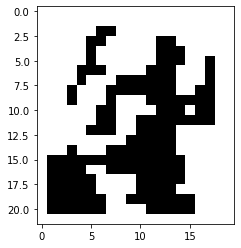

In [5]:
Lavoisier = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
SizeW, SizeH = (20, 22)  # size of the picture
draw(Lavoisier)

# Compression and coding

In [6]:
stream = Lavoisier.ravel()
lenstream = len(stream)
print('raw bit stream:\n', stream, '\nlength:',lenstream)

raw bit stream:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
length: 440


In [7]:
streamcs = np.array(addcs(stream))                # add the checksum
lenstreamcs = len(streamcs)
print('stream with added checksum:\n', streamcs, '\nlength:',lenstreamcs)

stream with added checksum:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] 
length: 441


In [8]:
# set-up the coder
N = 8                               # we'll code on 8bits
C = ARCoder(N, verbose=False)       # create the code
C.set_signal(streamcs)              # set the signal - computes the frequency table
freq_table = C.freqs                # and store it
# print("frequency table:\n",freq_table.frequencies)     # uncomment to print the frequency table   

In [9]:
# do the compression
compstream = np.array(C.compress())
complength = len(compstream)
print('compressed stream:\n', compstream, '\nlength:', complength, 'bits' )
print ("that's a %.0f%% reduction compared to non compressed"%(100*(1-complength/len(streamcs))))

compressed stream:
 [0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1
 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1
 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1
 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 1] 
length: 264 bits
that's a 40% reduction compared to non compressed


# chemical message to synthetize:

In [10]:
msgLavoisier = sig2msg(compstream)
print('message:')
print(*msgLavoisier, sep='-')
print('length:', len(msgLavoisier), 'monomers')

message:
M1-M1-M2-M7-M7-M4-M2-M8-M8-M3-M4-M4-M8-M7-M4-M1-M7-M4-M2-M7-M7-M5-M6-M5-M8-M6-M1-M5-M6-M8-M6-M5-M8-M6-M6-M2-M2-M3-M7-M5-M1-M6-M5-M4-M2-M7-M5-M2-M4-M8-M6-M1-M8-M3-M1-M8-M8-M5-M5-M6-M8-M1-M2-M8-M1-M8-M7-M2-M8-M3-M2-M4-M6-M1-M8-M8-M5-M8-M8-M4-M1-M8-M4-M4-M4-M2-M6-M8
length: 88 monomers


# decoding the message

In [11]:
# first decode the message into a compressed signal
decstream = msg2sig(msgLavoisier)
print('decoded signal:\n',decstream)

decoded signal:
 [0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1
 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1
 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1
 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 1]


In [12]:
# decode the signal
D = ARCoder(N, verbose=False)          # create the decoder
D.set_freq(freq_table)                 # load the frequency table
decoded = D.decomp(decstream) 
decoded = np.array(decoded[:lenstreamcs])
decoded = checkcs(decoded)
print('decoded signal\n',decoded)

valid checksum
decoded signal
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# and finally, the decoded picture

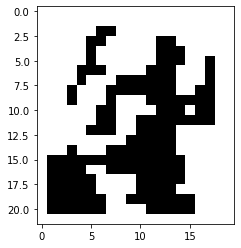

In [13]:
draw(decoded)